In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
movies = pd.read_csv("mv-1m_movies_rf.csv")
ratings = pd.read_csv("mv-1m_rating_rf.csv")
users = pd.read_csv("mv-1m_user_rf.csv")

In [3]:
links_Meta = pd.read_csv("links_Meta.csv")

In [4]:
#some genres are missing in movie_data
print(movies.head(2)) 
print('\n')
print(ratings.head(2))
print('\n')
print(users.head(2))
print('\n')
print(links_Meta.head(2))

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        2    Jumanji (1995)                   Adventure|Children|Fantasy   

   year  
0  1995  
1  1995  


   userId  movieId  rating
0       1     1193       5
1       1      661       3


   userId gender  age     occupation zipcode
0       1      F    1   K-12 student   48067
1       2      M   56  self-employed   70072


   movieId  imdbId  tmdbId                                          meta_data
0        1  114709   862.0  {'adult': False, 'backdrop_path': '/3Rfvhy1Nl6...
1        2  113497  8844.0  {'adult': False, 'backdrop_path': '/dH5BdTa6iS...


In [5]:
#24 entries are missing in genre
movies.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3859 non-null   object
 3   year     3883 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 121.5+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype
---  ------   --------------    -----
 0   userId   1000209 non-null  int64
 1   movieId  1000209 non-null  int64
 2   rating   1000209 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [ ]:
users.info()

In [7]:
#some userID movieID were in integer format so changed the formAT FOR ALL THE DATA
movies["movieId"] = movies["movieId"].astype(str)
ratings[['userId','movieId']] =ratings[['userId', 'movieId']].astype(str)
users['userId'] = users['userId'].astype(str)
links_Meta["movieId"] = links_Meta["movieId"].astype(str)

In [8]:
#all users in users dataset are one line entry
users["userId"].nunique()

6040

In [9]:
#ratings are integers from 1 to 5
print(ratings["rating"].value_counts())
print(ratings.nunique())

4    348971
3    261197
5    226310
2    107557
1     56174
Name: rating, dtype: int64
userId     6040
movieId    3706
rating        5
dtype: int64


In [10]:
#ALL USERS have given alteast 1 rating
# ALL Movies DOES NOT have ratings (about 177 movies dont have rating)

from pandasql import sqldf 
mysql = lambda q: sqldf(q, globals())
query = '''
SELECT count(distinct movieId)
FROM movies
where movieId not in (select distinct movieId from ratings);
'''
mysql(query)  

,count(distinct movieId)
0,177


In [11]:
# MADE THE YEAR column in the movies datadet
#movies["year"] =
movies["year"] = movies["title"].str[-5:].str[:-1]

In [12]:
#insights in user data
users.head(2)

,userId,gender,age,occupation,zipcode
0,1,F,1,K-12 student,48067
1,2,M,56,self-employed,70072


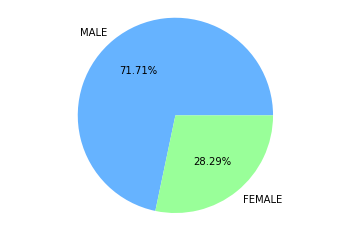

In [13]:
labels = ["MALE", "FEMALE"]
plt.pie(users["gender"].value_counts(), colors = ['#66b3ff','#99ff99'], autopct="%.2f%%",labels=labels)
plt.axis("equal")
plt.show()

In [14]:
#80% of the population is younger population
age_freq = users["age"].value_counts(normalize=True)
#print(dummy)

<AxesSubplot:>

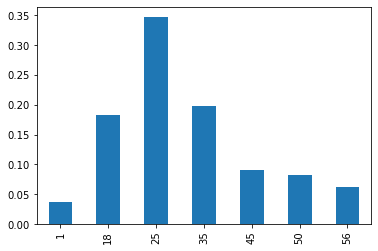

In [15]:
age_freq[age_freq.index.sort_values()].plot(kind='bar')

In [16]:
users["occupation"].value_counts().head(5)

college/grad student    759
other/ns                711
executive/managerial    679
academic/educator       528
technician/engineer     502
Name: occupation, dtype: int64

In [17]:
users["zipcode"].nunique()

3439

In [ ]:
links_Meta.head(2)

In [18]:
#Basically calculating the counts of movies that are drama based or comedy or thriller etc
#These Genres are not disjoint sets (they do have common movies)
from pandasql import sqldf 
mysql = lambda q: sqldf(q, globals())
def genre_count(x):
    query = '''
    
    SELECT count(*) as count
    FROM movies
    WHERE genres like '%{}%';
    '''.format(x)
    return mysql(query).loc[0,"count"]

In [19]:
genre_master = pd.read_csv("Genre_list.csv")

In [20]:
genre_master["counts"] = genre_master["genre_category"].apply(genre_count)

In [ ]:
genre_master.to_csv('Genre_List_with_counts.csv',index=False) 

In [21]:
total_movies = movies["movieId"].nunique()
total_movies

3883

In [22]:
genre_master["%counts"] = genre_master["counts"]/total_movies

<AxesSubplot:xlabel='genre_category', ylabel='%counts'>

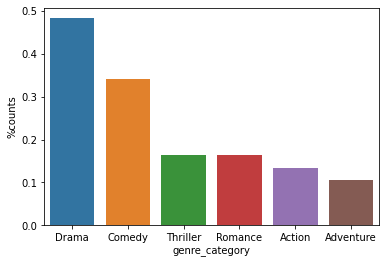

In [23]:
genre_master.sort_values(by = ['%counts'], ascending = [False],inplace= True)
sns.barplot(x='genre_category',y='%counts',data=genre_master.head(6),estimator=np.sum)

## MERGING ALL THE DATASETS

In [24]:
#From year 1919 to 2000 year movies are kept
year_freq = movies["year"].value_counts(normalize=True)
year_freq.index.min()

'1919'

In [26]:
ratings.sort_values(by = ['userId', 'movieId'], ascending = [True, True],inplace=True)
movies.sort_values(by = ['movieId'], ascending = [True],inplace=True)

In [27]:
ratings = ratings.merge(movies,left_on=['movieId'],right_on=['movieId'],how="left")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   userId   1000209 non-null  object
 1   movieId  1000209 non-null  object
 2   rating   1000209 non-null  int64 
 3   title    1000209 non-null  object
 4   genres   998034 non-null   object
 5   year     1000209 non-null  object
dtypes: int64(1), object(5)
memory usage: 53.4+ MB


In [28]:
links_Meta.sort_values(by = ['movieId'], ascending = [True],inplace=True)

In [29]:
ratings = ratings.merge(links_Meta[["movieId","meta_data"]],left_on=['movieId'],right_on=['movieId'],how="left")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1000209 non-null  object
 1   movieId    1000209 non-null  object
 2   rating     1000209 non-null  int64 
 3   title      1000209 non-null  object
 4   genres     998034 non-null   object
 5   year       1000209 non-null  object
 6   meta_data  998034 non-null   object
dtypes: int64(1), object(6)
memory usage: 61.0+ MB


In [30]:
users.sort_values(by = "userId",ascending = [True],inplace=True)
ratings.sort_values(by = "userId",ascending = [True],inplace=True)

In [31]:
ratings = ratings.merge(users,left_on=['userId'],right_on=['userId'],how="left")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userId      1000209 non-null  object
 1   movieId     1000209 non-null  object
 2   rating      1000209 non-null  int64 
 3   title       1000209 non-null  object
 4   genres      998034 non-null   object
 5   year        1000209 non-null  object
 6   meta_data   998034 non-null   object
 7   gender      1000209 non-null  object
 8   age         1000209 non-null  int64 
 9   occupation  1000209 non-null  object
 10  zipcode     1000209 non-null  object
dtypes: int64(2), object(9)
memory usage: 91.6+ MB


## Ratings + users + meta_Data + Movies (combo data is ratings_v2.csv)

In [ ]:
#DATA IS MERGED NOW
ratings.to_csv('ratings_v2.csv',index=False) 

In [32]:
  from pandasql import sqldf 
mysql = lambda q: sqldf(q, globals())
query = '''
SELECT movieId , title , genres, year,meta_data , count(DISTINCT userId) as distinct_user_Count, count(*) as count_of_ratings, sum(rating) as sum_ratings
FROM ratings
group by movieId,title,genres,year,meta_data
'''
movie_summary = mysql(query)

### movie_Summary (= movie_wise_summary.csv) is derived from ratings_v2 data

In [33]:
movie_summary["sum_ratings"].sum()

3582313

In [34]:
movie_summary.head(2)

,movieId,title,genres,year,meta_data,distinct_user_Count,count_of_ratings,sum_ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"{'adult': False, 'backdrop_path': '/3Rfvhy1Nl6...",2077,2077,8613
1,10,GoldenEye (1995),Action|Adventure|Thriller,1995,"{'adult': False, 'backdrop_path': '/8o9FsYGpQg...",888,888,3144


In [35]:
movie_summary.to_csv('movies_wise_summary.csv',index=False) 

In [36]:
movie_summary["average_rating"] = movie_summary["sum_ratings"] / movie_summary["count_of_ratings"]

In [37]:
movie_summary.head(2)

,movieId,title,genres,year,meta_data,distinct_user_Count,count_of_ratings,sum_ratings,average_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"{'adult': False, 'backdrop_path': '/3Rfvhy1Nl6...",2077,2077,8613,4.146846
1,10,GoldenEye (1995),Action|Adventure|Thriller,1995,"{'adult': False, 'backdrop_path': '/8o9FsYGpQg...",888,888,3144,3.540541


In [38]:
#tHE DISTINCT_USER_COUNT == COUNT_OF RATINGS = NO_OF_WATCHES (ek user ne ek movie ko ek baar se zyada rate nhn kiya)
movie_summary[~(movie_summary["count_of_ratings"]==movie_summary["distinct_user_Count"])]

,movieId,title,genres,year,meta_data,distinct_user_Count,count_of_ratings,sum_ratings,average_rating


In [39]:
movie_summary.drop('distinct_user_Count',axis=1,inplace=True)

In [40]:
movie_summary.head(2)

,movieId,title,genres,year,meta_data,count_of_ratings,sum_ratings,average_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"{'adult': False, 'backdrop_path': '/3Rfvhy1Nl6...",2077,8613,4.146846
1,10,GoldenEye (1995),Action|Adventure|Thriller,1995,"{'adult': False, 'backdrop_path': '/8o9FsYGpQg...",888,3144,3.540541


In [41]:
#Total watches must be equal to total ratings
movie_summary["count_of_ratings"].sum()  

1000209

# Most_Popular_Movies

### As per No of Ratings (watched)

In [42]:
movie_summary.sort_values(by = ["count_of_ratings","average_rating"],ascending=[False, False])[["title","count_of_ratings","average_rating"]].head(10)

,title,count_of_ratings,average_rating
1916,American Beauty (1999),3428,4.317386
1640,Star Wars: Episode IV - A New Hope (1977),2991,4.453694
191,Star Wars: Episode V - The Empire Strikes Back...,2990,4.292977
208,Star Wars: Episode VI - Return of the Jedi (1983),2883,4.022893
3182,Jurassic Park (1993),2672,3.763847
1025,Saving Private Ryan (1998),2653,4.337354
3301,Terminator 2: Judgment Day (1991),2649,4.058513
1610,"Matrix, The (1999)",2590,4.315830
272,Back to the Future (1985),2583,3.990321
3306,"Silence of the Lambs, The (1991)",2578,4.351823


### As per average rating

In [43]:
movie_summary.sort_values(by = ["average_rating","count_of_ratings"],ascending=[False,False])[["title","average_rating","count_of_ratings"]].head(4)

,title,average_rating,count_of_ratings
3492,"Gate of Heavenly Peace, The (1995)",5.0,3
2317,Smashing Time (1967),5.0,2
807,Follow the Bitch (1998),5.0,1
2256,Ulysses (Ulisse) (1954),5.0,1


In [ ]:
#One Observation highest on an average rated movies have less no of votes (few people are voting)

### As per Genre (also returning more than 1 column in apply function)

In [44]:
from pandasql import sqldf 
mysql = lambda q: sqldf(q, globals())
def genre_count(x):
    query = '''
    SELECT sum(count_of_ratings) as Total_votes , sum(average_rating * count_of_ratings) as Total_sum_of_Ratings
    FROM movie_summary
    WHERE genres like '%{}%';
    '''.format(x)
    
    df =pd.Series(mysql(query).values.reshape(2,))
# the above expression of df is when we want to return multiple columns for one entry we convert the return into series.    
    return df

#pd.Series(list(mysql(query)))
genre_master = pd.read_csv("Genre_list.csv")

In [45]:
genre_master_cols = genre_master["genre_category"].apply(lambda x: genre_count(x))

In [46]:
genre_master = pd.concat([genre_master,genre_master_cols],axis=1)

In [47]:
genre_master.head(2)

,genre_category,0,1
0,Action,253868.0,886292.0
1,Adventure,198548.0,708892.0


In [48]:
genre_master.dropna(inplace = True)

In [49]:
genre_master.head(2)

,genre_category,0,1
0,Action,253868.0,886292.0
1,Adventure,198548.0,708892.0


In [50]:
genre_master.rename(columns = {0:'Total_Votes',1:"Total_sum_of_Rating"}, inplace = True)

In [ ]:
genre_master.to_csv('Genre_List_with_popularity.csv',index=False) 

In [51]:
genre_master.head(2)

,genre_category,Total_Votes,Total_sum_of_Rating
0,Action,253868.0,886292.0
1,Adventure,198548.0,708892.0


In [52]:
movie_summary.head(2)

,movieId,title,genres,year,meta_data,count_of_ratings,sum_ratings,average_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,"{'adult': False, 'backdrop_path': '/3Rfvhy1Nl6...",2077,8613,4.146846
1,10,GoldenEye (1995),Action|Adventure|Thriller,1995,"{'adult': False, 'backdrop_path': '/8o9FsYGpQg...",888,3144,3.540541


In [53]:
movie_summary = pd.read_csv("movies_wise_summary.csv")
ratings = pd.read_csv("ratings_v2.csv")

In [54]:
movie_summary.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3706 entries, 0 to 3705
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   movieId              3706 non-null   int64 
 1   title                3706 non-null   object
 2   genres               3685 non-null   object
 3   year                 3706 non-null   int64 
 4   meta_data            3685 non-null   object
 5   distinct_user_Count  3706 non-null   int64 
 6   count_of_ratings     3706 non-null   int64 
 7   sum_ratings          3706 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 231.8+ KB


# MAGICAL function map(eval, )

In [ ]:
# MAGICAL FUNCTION
#eval strips out the string and evaluates the inner expression and map function helps us to apply that function
pd.DataFrame(map(eval,a))

In [ ]:
#21 movies dont have the metadata (out of 3706 movies)
movie_summary.info()
movie_summary_v2 = movie_summary[~(movie_summary["meta_data"].isnull())]

In [ ]:
movie_summary_v2.info()

In [ ]:
#Here first the 0 index entry is converted and then we further concatenate each individual dataframes.
a = pd.Series(movie_summary_v2["meta_data"][0])
df0 = pd.DataFrame(map(eval,a))

In [ ]:
#can directly start from here

In [ ]:
for i in range (1,len(movie_summary_v2["meta_data"])):
    a = pd.Series(movie_summary_v2["meta_data"].iloc[i])
    df1= pd.DataFrame(map(eval,a))
    df0 = pd.concat([df0,df1])

In [ ]:
df0.to_csv('meta_data.csv',index=False) 

In [ ]:
df0.drop(["status_message","status_code","success"],axis=1,inplace=True)
df0.head(1)

In [ ]:
movie_summary_v2.head(2)
df0.head(2)

In [ ]:
df0.drop("index",axis=1,inplace=True)

In [ ]:
df0.head(2)

In [ ]:
movie_summary_v3 = pd.concat([movie_summary_v2,df0],axis=1)

In [ ]:
movie_summary_v3.head(1)
movie_summary_v3.drop("level_0",axis=1,inplace=True)

In [ ]:
movie_summary_v3.to_csv("movies_wise_summary_V2.csv",index=False)


In [55]:
movie_summary_v3 = pd.read_csv("movies_wise_summary_V2.csv")

In [ ]:
movie_summary_v3.info()

### EDA of movie_summary_v3

In [56]:
# NO MOVIE in the metadata is an adult movie
movie_summary_v3.drop(["meta_data"],axis=1,inplace=True)

In [57]:
movie_summary_v3.head(2)

,movieId,title,genres,year,distinct_user_Count,count_of_ratings,sum_ratings,average_rating,adult,backdrop_path,...,release_date,revenue,runtime,spoken_languages,status,tagline,title.1,video,vote_average,vote_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,2077,2077,8613,4.146846,False,/3Rfvhy1Nl6sSGJwyjb0QiZzZYlB.jpg,...,1995-10-30,373554033.0,81.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Toy Story,False,8.0,15192.0
1,10,GoldenEye (1995),Action|Adventure|Thriller,1995,888,888,3144,3.540541,False,/8o9FsYGpQgRrpASU38L4gcgxchw.jpg,...,1995-11-16,352194034.0,130.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.9,3060.0


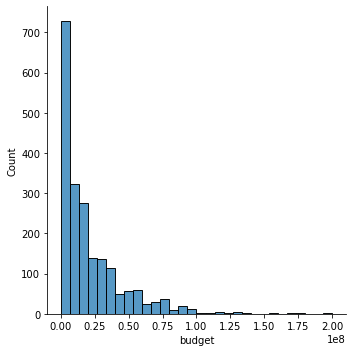

In [58]:
#About 1600 movies dont have budget value (ie roughly 50% is missing or NA)
#Budget doesnt seems to be reliable
sns.displot(movie_summary_v3[~(movie_summary_v3["budget"] == 0)]["budget"],kde=False,bins=30)

<AxesSubplot:>

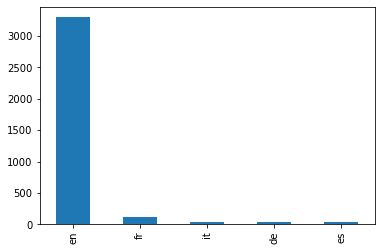

In [59]:
#Maximum movies (3299) are english movies (more than 90%)
movie_summary_v3["original_language"].value_counts().head(5).plot(kind='bar')

In [60]:
#Top 5 sequels that are made
movie_summary_v3["original_title"].value_counts().head(5)

Hamlet                     4
The Mummy                  3
True Crime                 2
The Thomas Crown Affair    2
The Fly                    2
Name: original_title, dtype: int64

In [61]:
#Top  5 production countries
movie_summary_v3["production_countries"].value_counts().head(5)

[{'iso_3166_1': 'US', 'name': 'United States of America'}]                                                    2389
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]                                                               176
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}, {'iso_3166_1': 'US', 'name': 'United States of America'}]     146
[]                                                                                                             125
[{'iso_3166_1': 'FR', 'name': 'France'}]                                                                        65
Name: production_countries, dtype: int64

In [62]:
#Top 5 movies wrt revenue
#revenue also about 1500 movies revenue is also missing
movie_summary_v3.sort_values(by = ["revenue"], ascending = [False])["title"].head(5)

713                                       Titanic (1997)
1661    Star Wars: Episode I - The Phantom Menace (1999)
3167                                Jurassic Park (1993)
3467                       Independence Day (ID4) (1996)
100                    E.T. the Extra-Terrestrial (1982)
Name: title, dtype: object

In [63]:
#Top 5 movies wrt budget
movie_summary_v3.sort_values(by = ["budget"], ascending = [False])["title"].head(5)

713                     Titanic (1997)
1074                 Waterworld (1995)
1739             Wild Wild West (1999)
1877          13th Warrior, The (1999)
552     Speed 2: Cruise Control (1997)
Name: title, dtype: object

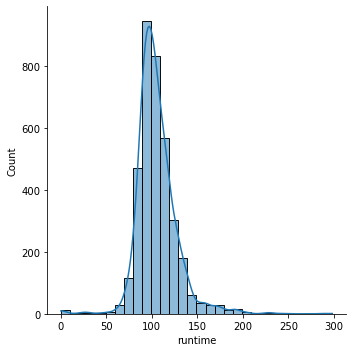

In [64]:
#max movies are 80min to 130 min
#It is somewhat normally distributed (which is natural)
sns.displot(movie_summary_v3["runtime"],bins=30,kde = True)

In [65]:
#all are released movies
movie_summary_v3["status"].value_counts()

Released    3666
Name: status, dtype: int64

In [66]:
#Only 3 movies have video
#all are released movies
movie_summary_v3["video"].value_counts()
movie_summary_v3["video"]==True

0       False
1       False
2       False
3       False
4       False
        ...  
3680    False
3681    False
3682    False
3683    False
3684    False
Name: video, Length: 3685, dtype: bool

# train test split of data

## 1) Stratified K fold

In [68]:
stratified_k_fold_data = ratings[["userId","movieId","rating"]]

In [69]:
X = stratified_k_fold_data.drop("rating",axis=1)

In [70]:
Y = stratified_k_fold_data["rating"]

In [ ]:
type(Y)

In [71]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5,shuffle = True,random_state=121)

In [72]:
test_indices = []
train_indices = []
for train, test in skf.split(X, Y):
    test_indices.append(test)
    train_indices.append(train)

In [73]:
test = pd.DataFrame(test_indices)
train = pd.DataFrame(train_indices)

In [ ]:
(test.T).to_csv('Test_indices.csv',index=False) 
(train.T).to_csv('Train_indices.csv',index=False)

In [ ]:
type(test_indices[0])

In [74]:
#pandas dataframe can take numpy arrays as it is
ratings.iloc[test_indices[0]].head(1)

,userId,movieId,rating,title,genres,year,meta_data,gender,age,occupation,zipcode
2,1,2762,4,"Sixth Sense, The (1999)",Drama|Horror|Mystery,1999,"{'adult': False, 'backdrop_path': '/6TjllWT3cG...",F,1,K-12 student,48067


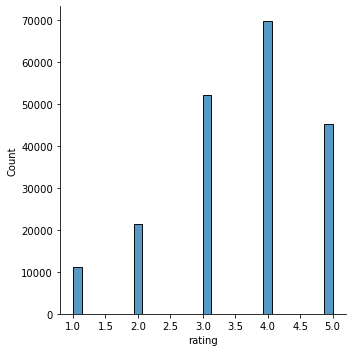

In [75]:
sns.displot(ratings.iloc[test_indices[4]]["rating"],kde=False,bins=30) 

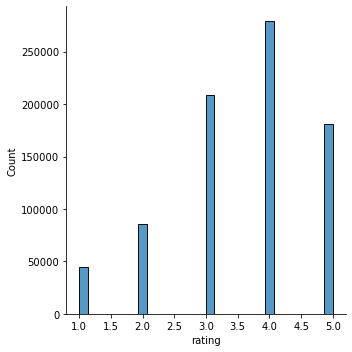

In [76]:
#ratings distribution is similar as per original mix of ratings
sns.displot(ratings.iloc[train_indices[4]]["rating"],kde=False,bins=30) 

## Checking The homogeneity of Train vs Test set

In [77]:
def splits_homogeneity (test_indices,train_indices,column_name):
    print(ratings.iloc[train_indices[2]][column_name].value_counts(normalize=True))
    print(ratings.iloc[test_indices[2]][column_name].value_counts(normalize=True))

In [78]:
splits_homogeneity(test_indices,train_indices,"gender")

M    0.753119
F    0.246881
Name: gender, dtype: float64
M    0.755581
F    0.244419
Name: gender, dtype: float64


In [79]:
splits_homogeneity(test_indices,train_indices,"age")

25    0.395169
35    0.199063
18    0.183843
45    0.083608
50    0.072476
56    0.038643
1     0.027198
Name: age, dtype: float64
25    0.396692
35    0.198553
18    0.182117
45    0.083647
50    0.072470
56    0.039287
1     0.027234
Name: age, dtype: float64


In [80]:
splits_homogeneity(test_indices,train_indices,"occupation")

college/grad student    0.131206
other/ns                0.130075
executive/managerial    0.105382
academic/educator       0.085345
technician/engineer     0.072671
writer                  0.060429
programmer              0.057500
artist                  0.050048
sales/marketing         0.049100
self-employed           0.046098
doctor/health care      0.037277
clerical/admin          0.031692
K-12 student            0.023253
scientist               0.022880
customer service        0.021733
lawyer                  0.020498
unemployed              0.014919
retired                 0.013775
tradesman/craftsman     0.012071
homemaker               0.011375
farmer                  0.002672
Name: occupation, dtype: float64
other/ns                0.132057
college/grad student    0.130198
executive/managerial    0.105488
academic/educator       0.085287
technician/engineer     0.073320
writer                  0.060207
programmer              0.056008
artist                  0.050094
sales/mark

In [81]:
splits_homogeneity(test_indices,train_indices,"year")

1999    0.086823
1998    0.068363
1997    0.065344
1995    0.060716
1996    0.059235
          ...   
1929    0.000045
1919    0.000044
1928    0.000025
1920    0.000021
1923    0.000016
Name: year, Length: 81, dtype: float64
1999    0.086782
1998    0.067606
1997    0.065566
1995    0.060842
1996    0.059907
          ...   
1919    0.000050
1929    0.000035
1928    0.000035
1920    0.000035
1923    0.000020
Name: year, Length: 81, dtype: float64


In [82]:
ratings.iloc[train_indices[4]]["movieId"].nunique()

3678

In [83]:
ratings["movieId"].nunique()

3706

In [ ]:
## After making word vectors of the column overview in the data

In [2]:
movies = pd.read_csv("movies_wise_summary_V3.csv")

In [3]:
ratings = pd.read_csv("ratings_v2.csv")

In [4]:
movies_cols_overview_features = pd.read_csv("movies_cols_overview_features.csv")

In [5]:
movies_cols_overview_features

,movie_ID,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1,-0.007683,0.026384,0.006943,0.034335,-0.021393,0.004546,0.007327,0.000506,-0.019714,...,0.038329,-0.008168,-0.037093,0.021605,-0.004748,-0.004782,-0.011903,0.076273,-0.022052,0.018435
1,10,-0.020265,-0.045637,0.012036,0.017123,-0.030701,-0.008272,0.002981,0.017303,-0.020702,...,0.080073,0.019278,-0.071625,0.022033,-0.027286,-0.001103,0.004762,0.101693,-0.015776,-0.000312
2,100,0.021511,-0.051671,0.024168,-0.028965,-0.003095,-0.007089,0.000030,0.021638,-0.025406,...,0.090319,0.005812,-0.049035,0.037827,-0.000083,-0.006398,-0.009938,0.160763,-0.004070,0.008144
3,1000,-0.007633,-0.045600,-0.000904,-0.006689,-0.025241,0.001934,0.034892,0.022041,-0.016284,...,0.032207,0.006866,-0.050663,0.028056,-0.020245,-0.002881,-0.008910,0.093447,-0.006515,0.010875
4,1002,0.011450,-0.023481,0.015800,-0.005494,-0.058987,-0.016749,-0.034590,0.000491,0.003089,...,0.035812,-0.015754,-0.116949,0.015472,-0.025483,-0.023112,0.000031,0.184257,-0.013806,0.014121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3680,994,-0.009432,0.005526,0.004546,0.044878,-0.009361,0.010226,0.018335,0.010930,-0.035502,...,0.045952,0.002105,-0.048846,-0.003807,-0.014541,-0.010892,-0.010246,0.107004,0.002195,0.014557
3681,996,-0.010360,-0.037774,0.001074,0.037739,-0.058099,-0.013744,0.047996,0.002472,-0.028401,...,0.054765,0.011577,-0.083370,0.024208,-0.021920,0.005003,-0.004654,0.157088,-0.008884,0.014273
3682,997,-0.001485,-0.059191,0.000441,0.030991,-0.039763,0.007942,0.033427,0.011748,-0.009260,...,0.032922,0.008482,-0.063593,0.034524,-0.033866,-0.012385,-0.006279,0.125288,-0.002714,0.012083
3683,998,-0.002131,-0.008336,-0.004438,0.007600,-0.046508,0.002474,0.020970,0.013058,-0.018263,...,0.015412,-0.000063,-0.085070,0.021058,-0.029216,-0.007364,0.006484,0.102255,-0.020328,0.006228


In [6]:
movie_vectors = movies_cols_overview_features.drop("movie_ID",axis=1)

In [7]:
movie_vectors.head(2)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.007683,0.026384,0.006943,0.034335,-0.021393,0.004546,0.007327,0.000506,-0.019714,0.009722,...,0.038329,-0.008168,-0.037093,0.021605,-0.004748,-0.004782,-0.011903,0.076273,-0.022052,0.018435
1,-0.020265,-0.045637,0.012036,0.017123,-0.030701,-0.008272,0.002981,0.017303,-0.020702,-0.003864,...,0.080073,0.019278,-0.071625,0.022033,-0.027286,-0.001103,0.004762,0.101693,-0.015776,-0.000312


In [8]:
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
cos_similarity  = cosine_similarity(movie_vectors.values)

In [10]:
cos_similarity_df = pd.DataFrame(cos_similarity)

In [11]:
cos_similarity_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,3675,3676,3677,3678,3679,3680,3681,3682,3683,3684
0,1.000000,0.849731,0.831016,0.815379,0.802069,0.871640,0.842294,0.872186,0.741375,0.835267,...,0.868910,0.890684,0.856132,0.834561,0.740658,0.835383,0.849279,0.841945,0.878668,0.805298
1,0.849731,1.000000,0.916288,0.920571,0.830521,0.921048,0.934463,0.835550,0.754897,0.917020,...,0.903258,0.881474,0.922610,0.915137,0.715783,0.866716,0.932248,0.899895,0.931181,0.910736


In [12]:
cos_similarity_df.columns = list(movies_cols_overview_features["movie_ID"])

In [13]:
cos_similarity_df.index = list(movies_cols_overview_features["movie_ID"])

In [14]:
cos_similarity_df.nlargest(5, [10]).index

Int64Index([10, 3248, 3301, 3286, 3627], dtype='int64')

In [15]:
#importing the test indices and the train indices
test_indices = pd.read_csv("Test_indices")
test_indices = test_indices.fillna(value=0)
test_indices = test_indices.astype(int)
test_indices = test_indices.round()

train_indices = pd.read_csv("Train_indices")
train_indices = train_indices.fillna(value=0)
train_indices = train_indices.astype(int)
train_indices =train_indices.round()


In [ ]:
#1st Fixing length of recommendation to be 5
def recomm_len_check (count,cos_similarity_df,list_of_movies_hist_orig,i):
    List_of_recommendations=[]
    recommendation_movie_i = set(cos_similarity_df.nlargest(5+count,i).index)
    list_of_movies_hist_dummy =list_of_movies_hist_orig.copy()
    list_of_movies_hist_dummy.update(recommendation_movie_i)
    
    if (len(list_of_movies_hist_dummy) == len(list_of_movies_hist_orig) +5): #because the both elements are sets (only 5 predictions per movie will come out)
        recommendation_movie_i = (recommendation_movie_i).difference(list_of_movies_hist_orig) #gives out the non common elements as predictions
        List_of_recommendations = list(recommendation_movie_i)
        
    else:
        count =count + (5-(len(list_of_movies_hist_dummy) - len(list_of_movies_hist_orig)))
        List_of_recommendations = recomm_len_check(count,cos_similarity_df,list_of_movies_hist_orig,i)
    return List_of_recommendations

In [ ]:


def recommendation (cos_similarity_df,movie_meta_data_miss,ratings,user_id):
    #creating distinct movie history of a particular user
    list_of_movies_hist = ratings[ratings["userId"] == user_id]["movieId"]
    list_of_movies_hist_orig = set(list_of_movies_hist).difference(set(movie_meta_data_miss))
    
    master_df = pd.DataFrame(index =[0,1,2,3,4])

    #list_of_Recommendation is list of Just Recommended Movies 
    #movie_seq is the order of movies in which recommendation is given
    movie_seq =[]
    #recommending top 5 movies
    for i in set(list_of_movies_hist_orig):
        count=0
        list_of_Recom_temp = recomm_len_check(count,cos_similarity_df,list_of_movies_hist_orig,i)
        df = pd.DataFrame(list_of_Recom_temp,columns=[i])
        master_df = pd.concat([master_df,df],axis=1)
    return master_df



In [ ]:
#this list of movies does not have meta data thats why removing these movies from the complete movies list 
movie_meta_data_miss = [1294,1758,1205,3935,1362,3027,3416,2645,3532,669,3366,978,3482,1741,863,811,1494,557,3842,578,1868] 

In [ ]:
#list of distinct UserID
list_of_user_ids = list(set(ratings["userId"]))
metric_df=pd.DataFrame(columns=["userID","metric","inter_section_count","movie_Recomm_count"])

In [ ]:
ratings["userId"].drop_duplicates().to_csv('userID_distinct.csv',index=False) 

#for user_id in list_of_user_ids:
# for user_id in list_of_user_ids:

In [ ]:
##*******START FROM HERE
train_data = ratings.iloc[train_indices["0"]]#change 0 to choose different split
test_movieid_userid  = ratings.iloc[test_indices["0"]][["movieId","userId"]]# can change the indice as per split column
   
for user_id in list_of_user_ids:
     recommendation_df_per_user = recommendation(cos_similarity_df,movie_meta_data_miss, ratings = train_data,user_id = user_id ) #change 1 ie user_id for which recommendation needs to be done  
    #flattening the dataframe and making unique recommendations
    
    #recommendation_df_per_user = pd.DataFrame(List_of_recommendations,index =movie_seq)
    unique_recommendations = np.unique(recommendation_df_per_user.to_numpy().flatten())

    #making unique movies out of test data for a particular USER
    test_movies_userid = test_movieid_userid[test_movieid_userid["userId"]==user_id]#change the 1 written for user id
    test_movies =  np.unique(test_movies_userid["movieId"].to_numpy().flatten())
    if len(test_movies) != 0:
        metric = len(np.intersect1d(unique_recommendations, test_movies)) / (len(test_movies))
        metric_df.loc[len(metric_df.index)] = [user_id,metric,len(np.intersect1d(unique_recommendations, test_movies)),len(unique_recommendations)] 
        print(metric_df.shape)
    else:
        continue
        

    

In [ ]:
metric_df.to_csv('metric_df',index=False)


In [ ]:
metric_df.to_csv('metric_df_v2.csv',index=False) 

## Surprise Library

In [16]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import Reader

In [19]:
svd = SVD(n_epochs=10,verbose=True) 
# (RMSE TRAIN AND validation)
# metrics in surprise (precision @K recall @K)

In [17]:
reader = Reader(rating_scale=(1, 5))

In [18]:
#making a surprise data object
trainset = Dataset.load_from_df(ratings[["userId","movieId",'rating']].iloc[train_indices["0"]],reader)
trainset = trainset.build_full_trainset()
testset = Dataset.load_from_df(ratings[["userId","movieId",'rating']].iloc[test_indices["0"]],reader)
testset = testset.build_full_trainset()

In [ ]:
svd.fit(trainset)

In [ ]:
ratings[ratings["rating"]==3].head(2)

In [ ]:
#uid = user id , iid = item id
svd.predict(uid=999, iid=1960)

In [16]:
list_movies = ratings["movieId"].unique()
list_users = ratings["userId"].unique()

In [ ]:
predicted_rating_matrix = np.zeros((len(list_users),len(list_movies)))
predicted_rating_matrix = pd.DataFrame(predicted_rating_matrix,index=list_users,columns=list_movies)

In [ ]:
#predicted_rating_matrix it is the whole matrix for all the combinations of users and movieIDs
for i in list_users:
    for j in list_movies:
        predicted_rating_matrix.loc[i,j] = svd.predict(uid=i, iid=j).est
        print([i,j])

In [ ]:
predicted_rating_matrix.to_csv('SVD_Predicted_rating.csv',index=False)
predicted_rating_matrix.to_csv('SVD_Predicted_rating.csv')

In [20]:
predicted_rating_matrix = pd.read_csv("SVD_Predicted_rating.csv",index_col=["index"])
type(predicted_rating_matrix)

pandas.core.frame.DataFrame

In [ ]:
predicted_rating_matrix

In [24]:
cols = pd.read_csv("cols.csv")
cols = cols["cols"].astype(int)

In [25]:
cols.values

array([   1, 2692, 2762, ...,  826,  814, 3209])

In [26]:
predicted_rating_matrix.columns = cols.values

In [27]:
predicted_rating_matrix.head(2)

,1,2692,2762,2791,2797,2804,2918,3105,3114,3186,...,576,2909,634,545,3647,792,2556,826,814,3209
index,,,,,,,,,,,,,,,,,,,,,
1,4.515421,4.256947,4.556794,3.871135,4.213404,4.341200,4.199070,4.02053,4.451939,3.615844,...,3.730884,3.730884,3.610454,3.533815,3.730884,3.470616,3.593427,3.661265,3.977649,3.708972
10,4.518729,4.467727,4.862451,3.954215,4.351797,4.377882,4.531659,4.36182,4.681989,3.931916,...,3.978580,3.978580,3.814828,3.930209,3.978580,4.087580,3.993352,3.824718,3.934145,3.704736


In [30]:
list_of_user_ids = set(ratings["userId"])
list_of_movies = set(ratings["movieId"])

In [31]:
pred_movie_vs_user = predicted_rating_matrix.T

In [32]:
pred_movie_vs_user.head(2)

index,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
1,4.515421,4.518729,3.466371,4.308031,4.168573,4.239206,4.426971,4.151303,4.475395,3.909265,...,4.073658,3.927924,3.991772,3.784471,4.087837,4.358362,4.582569,4.082492,4.199935,3.772266
2692,4.256947,4.467727,3.744619,4.377352,4.517009,4.347938,4.257558,4.036616,4.426134,4.062024,...,4.295581,3.904096,4.038392,3.931227,4.377488,4.291969,4.410298,4.094436,4.313119,3.674445


In [ ]:
#Top 10 Recommendations basis svd predicted matrix and removing those movies which the user has already seen
df2_cum = pd.DataFrame(np.zeros((10,1)))

test_movieid_userid  = ratings.iloc[test_indices["0"]][["movieId","userId"]]# can change the indice as per split column
metric_df=pd.DataFrame(columns=["userID","metric","inter_section_count","movie_Recomm_count"])
training_data = ratings.iloc[train_indices["0"]][["movieId","userId"]]

for users in list(list_of_user_ids):
    #creating distinct movie history of a particular user
    list_of_movies_hist = (training_data[training_data["userId"] == users]["movieId"])
    #total movies - training data
    list_of_movies_possible = list(list_of_movies.difference(set(list_of_movies_hist)))
    recommendation_movie_i = set(pred_movie_vs_user.loc[list_of_movies_possible,:].nlargest(10,users).index)

    df1 = pd.DataFrame(recommendation_movie_i,columns=[users])
    df2_cum = pd.concat([df2_cum,df1],axis=1)

    test_movies_userid = test_movieid_userid[test_movieid_userid["userId"]==users]#change the 1 written for user id
    test_movies =  np.unique(test_movies_userid["movieId"].to_numpy().flatten())
    
    if len(test_movies) != 0:
        metric = len(np.intersect1d(np.array(list(recommendation_movie_i)), test_movies)) / (len(test_movies))
        metric_df.loc[len(metric_df.index)] = [users,metric,len(np.intersect1d(np.array(list(recommendation_movie_i)), test_movies)),len(np.array(list(recommendation_movie_i)))] 
        print(metric_df.shape)
    else:
        continue

In [70]:
metric_df.to_csv('SVD_Output_10.csv',index=False)

### SVD optimization

In [44]:
svd = SVD(n_epochs=10,verbose=True) 
# (RMSE TRAIN AND validation)
# metrics in surprise (precision @K recall @K)

In [52]:
#making a surprise data object
trainset = Dataset.load_from_df(ratings[["userId","movieId",'rating']].iloc[train_indices["0"]],reader)
trainset = trainset.build_full_trainset()

In [46]:
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [54]:
trainset = Dataset.load_from_df(ratings[["userId","movieId",'rating']].iloc[train_indices["0"]],reader)
testset = Dataset.load_from_df(ratings[["userId","movieId",'rating']].iloc[test_indices["0"]],reader)

In [62]:
#in actual we are not doing any test_train split (this is only done so that accuracy function of surprise package could have been applied)

from surprise.model_selection import train_test_split
a , b_train = train_test_split(trainset, test_size=1.00)

In [65]:
a , b_test = train_test_split(testset, test_size=1.00)

In [69]:
predictions_test = svd.test(b_test)
predictions_train = svd.test(b_train)

In [70]:
from surprise import accuracy
accuracy.rmse(predictions_test)
accuracy.rmse(predictions_train)

RMSE: 0.8919
RMSE: 0.8095


0.809546249539898

In [19]:
#checking for performance on varying epochs
from surprise.model_selection import train_test_split
#epochs_count = [0,1,2,3,4,5,6,7,8,9,10,15,16,20,21,100]
epochs_count = [25,30,35,40,50,60,70]
trainset = Dataset.load_from_df(ratings[["userId","movieId",'rating']].iloc[train_indices["0"]],reader)
testset = Dataset.load_from_df(ratings[["userId","movieId",'rating']].iloc[test_indices["0"]],reader)

trainset_v2_only_training = trainset.build_full_trainset()

df_epochs = pd.DataFrame(columns=["epochs","RMSE_Train","RMSE_Test"])

In [ ]:
for epochs in epochs_count:
    svd = SVD(n_epochs=epochs)
    a , b_train = train_test_split(trainset, test_size=1.00)
    a , b_test = train_test_split(testset, test_size=1.00)
    svd.fit(trainset_v2_only_training)
    
    predictions_train = svd.test(b_train)
    predictions_test = svd.test(b_test)
    
    train = accuracy.rmse(predictions_train)
    test = accuracy.rmse(predictions_test)
    
    df_epochs.loc[len(df_epochs.index)] = [epochs,train,test]

RMSE: 0.6167
RMSE: 0.8776
RMSE: 0.5741
RMSE: 0.8840


In [ ]:
df_epochs.to_csv('SVD_optimization_more_examples.csv',index=False)

In [ ]:
df_epochs.to_csv('SVD_optimization_more_examples',index=False)

In [78]:
df_epochs.to_csv('SVD_optimization',index=False)

In [79]:
df_epochs.to_csv('SVD_optimization.csv',index=False) 

In [ ]:
#precision@k and recall@k

In [25]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


data =  Dataset.load_from_df(ratings[["userId","movieId",'rating']],reader)
kf = KFold(n_splits=5)
algo = SVD()


for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.9480039754845286
0.385302407029629
0.9476352284656787
0.38416321887807653
0.9500358957367073
0.3835671357401596
0.950372763419499
0.38520479525367957
0.9498535830709052
0.3853738983003348


In [ ]:
SVD()

data.reshape(len(movie_seq,5),inplace=True)
## GROUP K FOLD

In [ ]:
train_indices["0"]

In [ ]:


#WHAT IS THE DEFINATION OF X in group K fold
#Group K fold does not works for multiple variables (only one column at a time is utilised)
ratings.info()

## model_Building

In [ ]:
master_df = pd.DataFrame()